# 특성 엔지니어링 작업

In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import soundfile as sf
# from sklearn.externals import joblib
import joblib

%matplotlib inline

In [2]:
ROOT_DIR = 'UrbanSound8K/audio/'
files = glob.glob(ROOT_DIR+'/**/*')

In [3]:
len(files)

8732

In [4]:
files[0].split('\\')[-1].split('-')[1]

'7'

_windows : 오디오 하위 샘플의 시작 및 종료 색을을 가져오는 함수_

In [5]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_resample = librosa.resample(data.T, fsr, sr)
    if len(data_resample.shape) > 1:
        data_resample = np.average(data_resample, axis=0)
    return data_resample, sr

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [6]:
d, sr = get_sound_data(files[0])

In [7]:
len(d), sr

(88200, 22050)

In [8]:
32256 / 22050

1.4628571428571429

extract_features
- _하기 이미지와 같이 특성 추출을 합니다._
![feature_extraction](assets/feature_extraction.PNG)

In [9]:
def extract_features(file_names, bands=64, frames=64):
    
    window_size = 512 * (frames - 1)  
    log_specgrams_full = []
    log_specgrams_hp = []
    class_labels = []
    # for each audio sample
    for fn in file_names:
        file_name = fn.split('\\')[-1]
        class_label = file_name.split('-')[1]
        sound_data, sr = get_sound_data(fn, sr=22050)
        # for each audio signal sub-sample window of data
        for (start,end) in windows(sound_data, window_size):
            if(len(sound_data[start:end]) == window_size):
                signal = sound_data[start:end]
                # get the log-scaled mel-spectrogram
                melspec_full = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec_full = librosa.amplitude_to_db(melspec_full)
                logspec_full = logspec_full.T.flatten()[:, np.newaxis].T
                # get the log-scaled, averaged values for the harmonic & percussive components
                y_harmonic, y_percussive = librosa.effects.hpss(signal)
                melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = bands)
                melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = bands)
                logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
                logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
                logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
                logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
                logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)
                
                log_specgrams_full.append(logspec_full)
                log_specgrams_hp.append(logspec_hp)
                class_labels.append(class_label)
    # create the first two feature maps            
    log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
    log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
    features = np.concatenate((log_specgrams_full, 
                               log_specgrams_hp, 
                               np.zeros(np.shape(log_specgrams_full))), 
                              axis=3)
    # create the third feature map which is the delta (derivative) of the log-scaled mel-spectrogram
    for i in range(len(features)):
        features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(class_labels, dtype = np.int)

In [12]:
features, labels = extract_features(files)

_64 x 64 x 3으로 특성 추출된 것을 확인 할 수 있습니다._

In [13]:
features.shape, labels.shape

((30500, 64, 64, 3), (30500,))

In [14]:
from collections import Counter

Counter(labels)

Counter({7: 3473,
         9: 4000,
         8: 3611,
         3: 2912,
         2: 3947,
         0: 3993,
         5: 3910,
         1: 913,
         4: 3405,
         6: 336})

In [15]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}

categories = list(set(labels))
sample_idxs = [np.where(labels == label_id)[0][0] for label_id in categories]
feature_samples = features[sample_idxs]
feature_samples.shape

(10, 64, 64, 3)

_3가지 특성 데이터를 imshow를 사용하여 이미지로 보이도록 합니다._

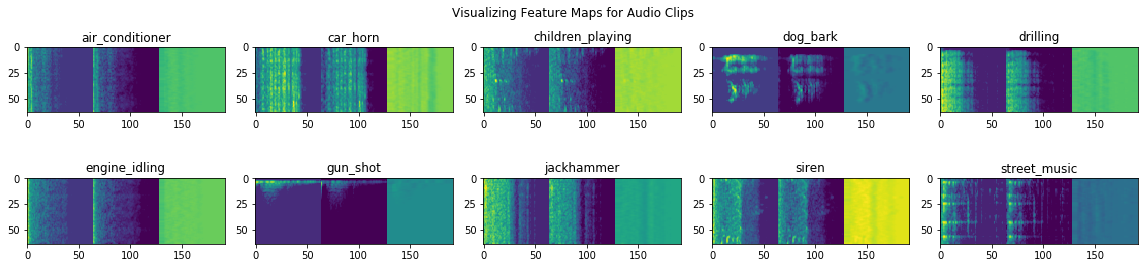

In [16]:
plt.figure(figsize=(16, 4))
for index, (feature_map, category) in enumerate(zip(feature_samples, categories)):
    plt.subplot(2, 5, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(class_map[str(category)])
plt.tight_layout()
t = plt.suptitle('Visualizing Feature Maps for Audio Clips')

In [17]:
joblib.dump(features, 'base_features.pkl')
joblib.dump(labels, 'dataset_labels.pkl')

['dataset_labels.pkl']

In [18]:
features = joblib.load('base_features.pkl')
labels = joblib.load('dataset_labels.pkl')
features.shape, labels.shape

((30500, 64, 64, 3), (30500,))

In [19]:
data = np.array(list(zip(features, labels)))
data.shape

(30500, 2)

_훈련, 검증, 테스트 데이터 구성_

In [20]:
np.random.shuffle(data)

In [21]:
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [22]:
train.shape, validate.shape, test.shape

((18300, 2), (6100, 2), (6100, 2))

In [23]:
print('Train:', Counter(item[1] for item in train), 
      '\nValidate:', Counter(item[1] for item in validate), 
      '\nTest:',Counter(item[1] for item in test))

Train: Counter({0: 2427, 9: 2414, 2: 2379, 5: 2323, 8: 2118, 7: 2098, 4: 2062, 3: 1735, 1: 539, 6: 205}) 
Validate: Counter({5: 854, 9: 798, 0: 783, 8: 736, 2: 723, 7: 712, 4: 660, 3: 579, 1: 184, 6: 71}) 
Test: Counter({2: 845, 9: 788, 0: 783, 8: 757, 5: 733, 4: 683, 7: 663, 3: 598, 1: 190, 6: 60})


[vgg ref](https://arxiv.org/abs/1409.1556)

In [24]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image

Using TensorFlow backend.


In [25]:
def process_sound_data(data):
    data = np.expand_dims(data, axis=0)
    data = preprocess_input(data)
    return data

- _include_top을 false로 하여 fully connected를 포함하지 않습니다._
- _모델 output에 max pooling을 flatten하였습니다. _

In [26]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))


output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

model = Model(vgg.input, output)
model.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

_특성 추출을 수행합니다._

In [27]:
def extract_tl_features(model, base_feature_data):
    dataset_tl_features = []
    for index, feature_data in enumerate(base_feature_data):
        if (index+1) % 1000 == 0:
            print('Finished processing', index+1, 'sound feature maps')
        pr_data = process_sound_data(feature_data)
        tl_features = model.predict(pr_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        dataset_tl_features.append(tl_features)
    return np.array(dataset_tl_features)

In [28]:
train_base_features = [item[0] for item in train]
train_labels = np.array([item[1] for item in train])
train_tl_features = extract_tl_features(model=model, base_feature_data=train_base_features)

Finished processing 1000 sound feature maps
Finished processing 2000 sound feature maps
Finished processing 3000 sound feature maps
Finished processing 4000 sound feature maps
Finished processing 5000 sound feature maps
Finished processing 6000 sound feature maps
Finished processing 7000 sound feature maps
Finished processing 8000 sound feature maps
Finished processing 9000 sound feature maps
Finished processing 10000 sound feature maps
Finished processing 11000 sound feature maps
Finished processing 12000 sound feature maps
Finished processing 13000 sound feature maps
Finished processing 14000 sound feature maps
Finished processing 15000 sound feature maps
Finished processing 16000 sound feature maps
Finished processing 17000 sound feature maps
Finished processing 18000 sound feature maps


In [29]:
joblib.dump(train_tl_features, 'train_tl_features.pkl')
joblib.dump(train_labels, 'train_labels.pkl')

['train_labels.pkl']

In [30]:
train_tl_features.shape, train_labels.shape

((18300, 2048), (18300,))

In [31]:
validate_base_features = [item[0] for item in validate]
validate_labels = np.array([item[1] for item in validate])
validate_tl_features = extract_tl_features(model=model, base_feature_data=validate_base_features)

Finished processing 1000 sound feature maps
Finished processing 2000 sound feature maps
Finished processing 3000 sound feature maps
Finished processing 4000 sound feature maps
Finished processing 5000 sound feature maps
Finished processing 6000 sound feature maps


In [32]:
joblib.dump(validate_tl_features, 'validate_tl_features.pkl')
joblib.dump(validate_labels, 'validate_labels.pkl')

['validate_labels.pkl']

In [33]:
test_base_features = [item[0] for item in test]
test_labels = np.array([item[1] for item in test])
test_tl_features = extract_tl_features(model=model, base_feature_data=test_base_features)

Finished processing 1000 sound feature maps
Finished processing 2000 sound feature maps
Finished processing 3000 sound feature maps
Finished processing 4000 sound feature maps
Finished processing 5000 sound feature maps
Finished processing 6000 sound feature maps


In [34]:
joblib.dump(test_tl_features, 'test_tl_features.pkl')
joblib.dump(test_labels, 'test_labels.pkl')

['test_labels.pkl']

In [35]:
train_tl_features.shape, validate_tl_features.shape, test_tl_features.shape

((18300, 2048), (6100, 2048), (6100, 2048))